In [18]:
import pickle
from collections import defaultdict
from framework.losses import interpoint_distance
import os
import pandas as pd

import matplotlib.pyplot as plt

In [19]:
SAVE_IMAGES = False
IMAGES_DIR = "./results/img/exp1/"

def clear_folder(path):
    filelist = [f for f in os.listdir(path) if f.endswith("png")]
    for f in filelist:
        os.remove(os.path.join(path, f))
        
def save_image(title, x, y):
    filename = title + ".png"
    plt.title(title)
    plt.plot(x, y)
    plt.savefig(IMAGES_DIR + filename)

In [20]:
RESULTS_DIR = "./results/exp1"
N_RESULT_FILES = 10

def _load(name):
    with open(name, "rb") as f:
        return pickle.load(f)

K_VALUES = [5, 10, 20, 30, 40, 50, 60]
EPSILON_VALUES = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

if SAVE_IMAGES:
    clear_folder(IMAGES_DIR)

In [21]:
def create_avg_data(RESULTS_DIR, N_RESULT_FILES):
    print("Listing all result files...")
    for filename in os.listdir(RESULTS_DIR):
        print(filename)
    
    if len(os.listdir(RESULTS_DIR)) != N_RESULT_FILES:
        print("Some runs are missing please check the results folder")
    
    print("---------------------------------------------------------")
    
    print("Combining files now....")
    exp2_runs = {}
    i=0
    print("Loading Data...")
    for run in os.listdir(RESULTS_DIR):
        result = _load(os.path.join(RESULTS_DIR, run))
        result = pd.DataFrame(result)
        result = result.drop(['emb_x', 'labels'], axis=1)
        
        exp2_runs[i] = result
        i +=1
        
    # ---------------------------------------------------------------------------------------- 
    
    # Scatter Table
    avg_scatter = exp2_runs[0].copy()
    avg_scatter = avg_scatter[avg_scatter['convergence'] == 'scatter']
    avg_scatter['loss'] = 0
    
    #Epsilon Precision-Recall Table:
    avg_epsilon_pr = exp2_runs[0].copy()
    avg_epsilon_pr = avg_epsilon_pr[avg_epsilon_pr['convergence'] == 'epsilon_precision_recall']
    for entry in range(len(avg_epsilon_pr)):
        for j in range(len(EPSILON_VALUES)):
            avg_epsilon_pr['loss'].iloc[entry][0][j] = 0
            avg_epsilon_pr['loss'].iloc[entry][1][j] = 0
            
    #NN and FN Precision Table
    avg_nn_pr = exp2_runs[0].copy()
    avg_nn_pr = avg_nn_pr[avg_nn_pr['convergence'] == 'nn_precision']
    avg_fn_pr = exp2_runs[0].copy()
    avg_fn_pr = avg_fn_pr[avg_fn_pr['convergence'] == 'fn_precision']
    
    for entry in range(len(avg_nn_pr)):
        for j in range(len(K_VALUES)):
            avg_nn_pr['loss'].iloc[entry][j] = 0
            avg_fn_pr['loss'].iloc[entry][j] = 0
    
    
    # Summing up
    for ind in range(N_RESULT_FILES):
        df = exp2_runs[ind]
        
        # Combine Scatter:
        avg_scatter['loss'] += df[df['convergence'] == 'scatter']['loss']
        
        # Combine Epsilon Precision Recall:
        df_ep = df[df['convergence'] == 'epsilon_precision_recall']
        
        for entry in range(len(avg_epsilon_pr)):
            for j in range(len(EPSILON_VALUES)):
                avg_epsilon_pr['loss'].iloc[entry][0][j] += df_ep['loss'].iloc[entry][0][j]
                avg_epsilon_pr['loss'].iloc[entry][1][j] += df_ep['loss'].iloc[entry][1][j]
                
        # Combine NN and FN Precision:
        df_nn = df[df['convergence'] == 'nn_precision']
        df_fn = df[df['convergence'] == 'fn_precision']
        
        for entry in range(len(avg_nn_pr)):
            for j in range(len(K_VALUES)):
                avg_nn_pr['loss'].iloc[entry][j] += df_nn['loss'].iloc[entry][j]
                avg_fn_pr['loss'].iloc[entry][j] += df_fn['loss'].iloc[entry][j]
    
    #Scaling down to get average:
    avg_scatter['loss'] = avg_scatter['loss'] / N_RESULT_FILES
    
    for entry in range(len(avg_epsilon_pr)):
        for j in range(len(EPSILON_VALUES)):
            avg_epsilon_pr['loss'].iloc[entry][0][j] = avg_epsilon_pr['loss'].iloc[entry][0][j]/N_RESULT_FILES
            avg_epsilon_pr['loss'].iloc[entry][1][j] = avg_epsilon_pr['loss'].iloc[entry][1][j]/N_RESULT_FILES
            
    for entry in range(len(avg_nn_pr)):
            for j in range(len(K_VALUES)):
                avg_nn_pr['loss'].iloc[entry][j] = avg_nn_pr['loss'].iloc[entry][j]/N_RESULT_FILES
                avg_fn_pr['loss'].iloc[entry][j] = avg_fn_pr['loss'].iloc[entry][j]/N_RESULT_FILES
    

    
    
        
    return avg_scatter, avg_epsilon_pr, avg_nn_pr, avg_fn_pr
        
        

In [22]:
avg_scatter, avg_epsilon_pr, avg_nn_pr, avg_fn_pr = create_avg_data(RESULTS_DIR, N_RESULT_FILES)

Listing all result files...
experimentone_9.pkl
experimentone_8.pkl
experimentone_10.pkl
experimentone_5.pkl
experimentone_4.pkl
experimentone_6.pkl
experimentone_7.pkl
experimentone_3.pkl
experimentone_2.pkl
experimentone_1.pkl
---------------------------------------------------------
Combining files now....
Loading Data...


## Scatter metric plots

In [23]:
def _plot_line(key, x, y):
    plt.title("Running {} on {} with {} sampling".format(key[1], key[0], key[2]))
    plt.ylabel("LDA Score")
    plt.xlabel("Fraction of dataset")
    plt.plot(x, y)
    if SAVE_IMAGES:
        plt.savefig(IMAGES_DIR + "scatter vs size for: {}".format(str(key)))
        plt.cla()
    else:
        plt.show()

def _fix_scatter(s_df):
    x_vals = defaultdict(list)
    y_vals = defaultdict(list)
    data = avg_scatter.to_dict('records')
    for datapoint in data:
        x_vals[tuple([datapoint['dataset'], datapoint['algorithm'], datapoint['sampling']])].append(datapoint['size'])
        y_vals[tuple([datapoint['dataset'], datapoint['algorithm'], datapoint['sampling']])].append(datapoint['loss'])
    return dict(x_vals), dict(y_vals)

In [24]:
x_data, y_data = _fix_scatter(avg_scatter)

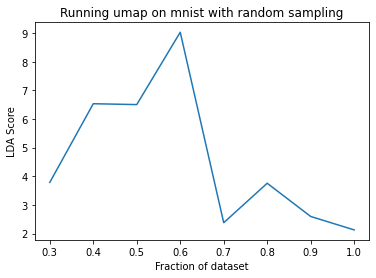

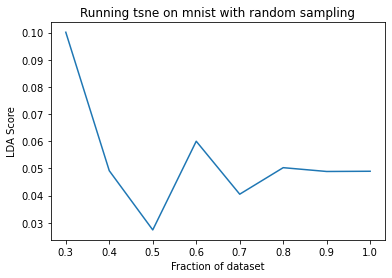

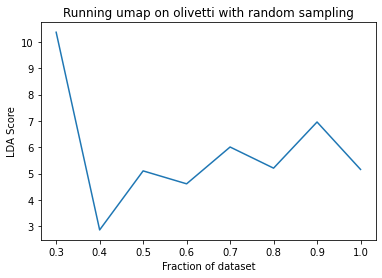

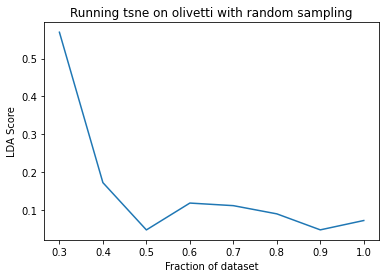

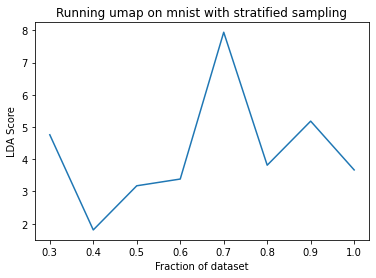

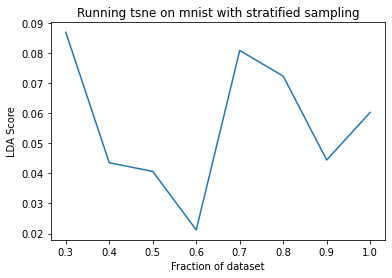

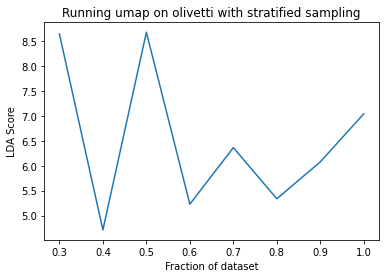

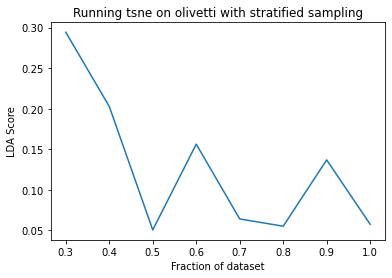

In [25]:
for key, x in x_data.items():
    _plot_line(key, x, y_data[key])

## fn vs nn plots

In [26]:
SIZES = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def _get_subset(df, dataset, sampling, algo):
    return df[df['dataset'] == dataset][df['sampling'] == sampling][df['algorithm'] == algo]

def _plot_subsets(y_df, x_df):
    for size in SIZES:
        y_loss = y_df[y_df['size'] == size]['loss'].tolist()[0]
        x_loss = x_df[x_df['size'] == size]['loss'].tolist()[0]
        plt.plot(x_loss, y_loss, label="Size={}".format(str(size)))

def draw_fn_nn(fn_df, nn_df):
    subsets = [("mnist", "random", "umap"),
               ("mnist", "random", "tsne"),
               ("mnist", "stratified", "umap"),
               ("mnist", "stratified", "tsne")]
    
    for subset in subsets:
        ds, samp, alg = subset
        fn_subset = _get_subset(fn_df, ds, samp, alg) # Y axis
        nn_subset = _get_subset(nn_df, ds, samp, alg) # X axis
        plt.ylabel("FN Score")
        plt.xlabel("NN Score")
        plt.title("Running {} on {} with {} sampling".format(subset[2], subset[0], subset[1]))
        _plot_subsets(fn_subset, nn_subset)
        plt.legend(loc="upper left")
        if SAVE_IMAGES:
            plt.savefig(IMAGES_DIR + "fn vs nn plots for: {}.png".format(subset))
            plt.cla()
        else:
            plt.show()

<ipython-input-26-d499f40d2dfc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['dataset'] == dataset][df['sampling'] == sampling][df['algorithm'] == algo]


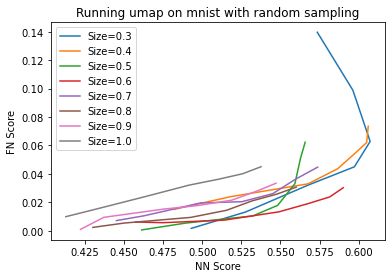

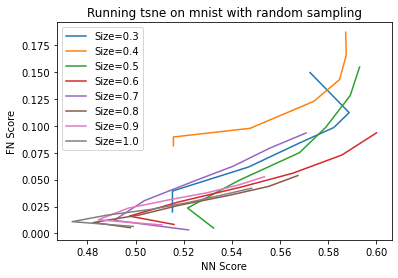

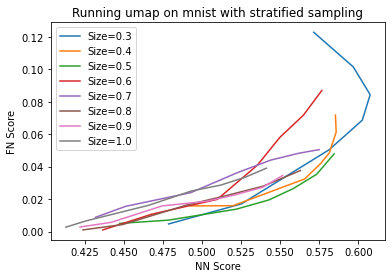

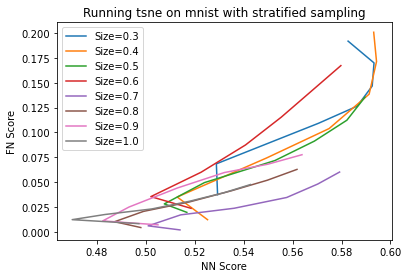

In [27]:
draw_fn_nn(avg_fn_pr, avg_nn_pr)

## Epsilon PR plots

In [28]:
import math

def _plot_subsets(df, pr):
    for size in SIZES:
        E = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
        E_log = [math.log10(x) for x in E]
        precision = df[df['size'] == size]['loss'].tolist()[0][0]
        recall = df[df['size'] == size]['loss'].tolist()[0][1]
        plt.xticks(E_log)
        y = precision if pr == "precision" else recall
        plt.plot(E_log, y, label="Size={}".format(str(size)))

def draw_epsilon_plot(e_df, pr="precision"):
    subsets = [("mnist", "random", "umap"),
               ("mnist", "random", "tsne"),
               ("mnist", "stratified", "umap"),
               ("mnist", "stratified", "tsne")]
    
    for subset in subsets:
        ds, samp, alg = subset
        e_subset = _get_subset(e_df, ds, samp, alg)
        plt.title("Running {} on {} with {} sampling".format(subset[2], subset[0], subset[1]))
        plt.ylabel("Recall" if pr == "recall" else "Precision")
        plt.xlabel("Log Epsilon")
        _plot_subsets(e_subset, pr)
        plt.legend(loc="upper right")
        if SAVE_IMAGES:
            plt.savefig(IMAGES_DIR + "log epsilon vs {} plots for: {}.png".format(pr, subset))
            plt.cla()
        else:
            plt.show()

<ipython-input-26-d499f40d2dfc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['dataset'] == dataset][df['sampling'] == sampling][df['algorithm'] == algo]


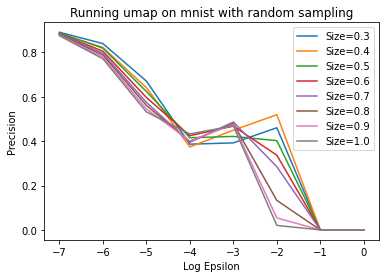

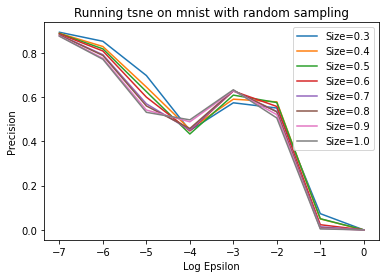

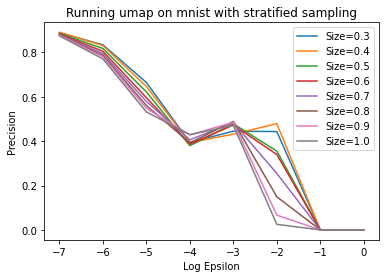

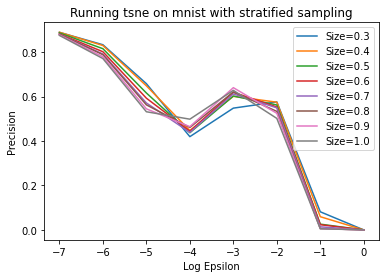

In [29]:
draw_epsilon_plot(avg_epsilon_pr)

<ipython-input-26-d499f40d2dfc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['dataset'] == dataset][df['sampling'] == sampling][df['algorithm'] == algo]


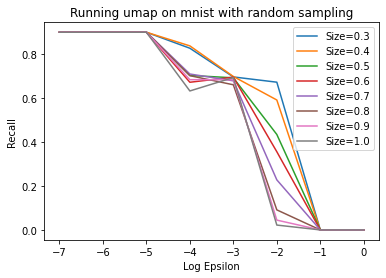

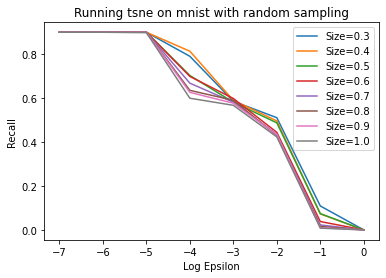

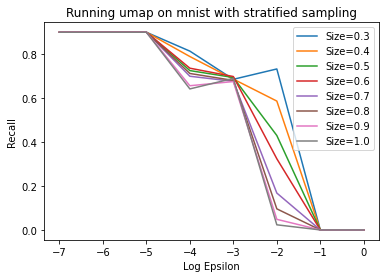

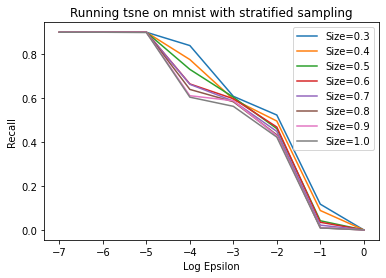

In [30]:
draw_epsilon_plot(avg_epsilon_pr, "recall")

## Plot mnist for one run

In [31]:
results = _load("./results/exp1/experimentone_1.pkl")
palette = plt.get_cmap('Set1')

In [32]:
def _search(x, size, sampling, ds, algorithm):
    for res in x:
        if res['size'] == size and res['sampling'] == sampling and res['dataset'] == ds and res['algorithm'] == algorithm:
            return res['emb_x'], res['labels']
    return None

In [33]:
def _plot_emb(size, sampling, ds, algo):
    data, y = _search(results, size, sampling, ds, algo)
    x_val = [x[0] for x in data]
    y_val = [x[1] for x in data]
    plt.scatter(x_val, y_val, color=palette(y))
    if SAVE_IMAGES:
        plt.savefig(IMAGES_DIR + "EMB_{}_{}_{}_{}.png".format(size, sampling, ds, algo))
    else:
        plt.show()

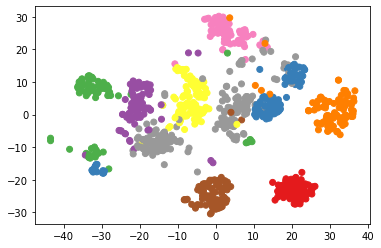

In [34]:
_plot_emb(0.5, "random", "mnist", "tsne")